# Carbon System Example Code

**Author: Andrew Reed**

### Purpose
The purpose of this notebook is to provide an example of working with ```PCO2W``` data from the Ocean Observatories Initiative. Example datasets are provided in the ```data``` directory. This code is meant to highlight necessary post-download processing steps to improve data quality and useability.

### Data
This notebook makes use of the PCO2W dataset from the Coastal Pioneer Central Surface Mooring (CP01CNSM) Seafloor Multi-Function-Node. This instrument is located at a latitude, longitude of 40.13678, -70.76978, at an approximate depth of 133 m on the New England Shelf break.

The example ```PCO2W``` datasets were downloaded as netCDF files from the Ocean Observatories Initiative data portal for all available, reformatted to clean up the dimensions, and then merged into one dataset. This process is outlined in the notebook **```Downloading_Data.ipynb```**. 

The discrete bottle data were downloaded from the OOI Alfresco Document Server at https://alfresco.oceanobservatories.org. The relevant files are in OOI > Coastal Pioneer Array > Cruise Data > "Cruise Directory" > Ship Data > Water Sampling > "Discrete Summary Sample Sheet.xlsx". For more information and an example of working with and validating discrete sample data please follow the **```Bottle_Data.ipynb```** example notebook. 

### Dependencies & Use
This notebook and related examples are all done using the Python programming language. Additionally, it relies on several github repositories and existing code bases for working with OOI data. The first is the OOINet repository at https://github.com/reedan88/OOINet. This repo hosts modules and tools that are designed to assist in requesting, importing, and downloading data from the Ocean Observatories Initiative API by M2M requests. It also utilizes code from the OOI Data Explorations repo at https://github.com/oceanobservatories/ooi-data-explorations. This repository contains modules, tools, and notebooks that also assist with downloading data from the OOI API, as well as extensive tools for processing the downloaded datasets to make them more user-friendly. Lastly, functions written specifically for this example notebook are stored in the utils.py module in the parent directory, allowing for direct imports.

In [1]:
# Import libraries
import os, sys, re
import yaml
import numpy as np
import pandas as pd
import xarray as xr
# Supress auto warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append("/home/areed/Documents/OOI/reedan88/ooinet/")
from ooinet import M2M
from ooinet.utils import convert_time, ntp_seconds_to_datetime, unix_epoch_time
from ooinet.Instrument.common import process_file, add_annotation_qc_flag

In [3]:
# Add plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.append("..")
from utils import *

---
## Load the data

First, we want to load the data into the notebook. Below, I utilize ```xarray``` to open and work with the dataset. ```xarray``` is optimized for working with multidimensional data and is especially useful for datasets which may be bigger than available memory on the computer. For our convience, an example dataset has already been downloaded and prepared for use here. An example of downloading and processing files is available in the ```Downloading_Data.ipynb``` notebook.

In [5]:
# Load the phsen dataset from the local directory, using "chunks" to keep the data in optimized dask arrays
pco2w = xr.open_dataset("../data/CP01CNSM-MFD35-05-PCO2WB000_combined.nc", chunks="auto")

# For convience, also set the reference designator name
refdes = "CP01CNSM-MFD35-05-PCO2WB000"

Look at the structure of the ```PCO2W``` dataset:

In [6]:
pco2w

<xarray.Dataset>
Dimensions:                             (time: 57547, duplicates: 2)
Coordinates:
  * duplicates                          (duplicates) int32 0 1
  * time                                (time) datetime64[ns] 2013-11-21T20:0...
Data variables: (12/23)
    absorbance_blank_434                (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    absorbance_blank_620                (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    absorbance_ratio_434                (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    absorbance_ratio_620                (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    battery_voltage                     (time) float32 dask.array<chunksize=(57547,), meta=np.ndarray>
    dark_reference                      (time, duplicates) float64 dask.array<chunksize=(57547, 2), meta=np.ndarray>
    ...                                  ...
    signal_434                          (time, duplicates) float64 dask.array<chunksize=(57547, 2), meta=np.ndarray>
    signal_620                          (time, duplicates) float64 dask.array<chunksize=(57547, 2), meta=np.ndarray>
    thermistor_temperature              (time) float32 dask.array<chunksize=(57547,), meta=np.ndarray>
    thermistor_temperature_qc_executed  (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    thermistor_temperature_qc_results   (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
    unique_id                           (time) float64 dask.array<chunksize=(57547,), meta=np.ndarray>
Attributes: (12/70)
    node:                               MFD35
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             pco2w_abc_instrument
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978
    Location_name:                      Coastal Pioneer Central Surface Moori...

The principle data variable we are interested in is the ```pco2_seawater``` variable. Other data variables we will be using are the ```deployment``` variable, which contains an entry for which deployment each timestamp corresponds to.

Now, plot the ```pco2_seawater``` data variable along with the relevant deployments to get an idea of when the instrument was changed.

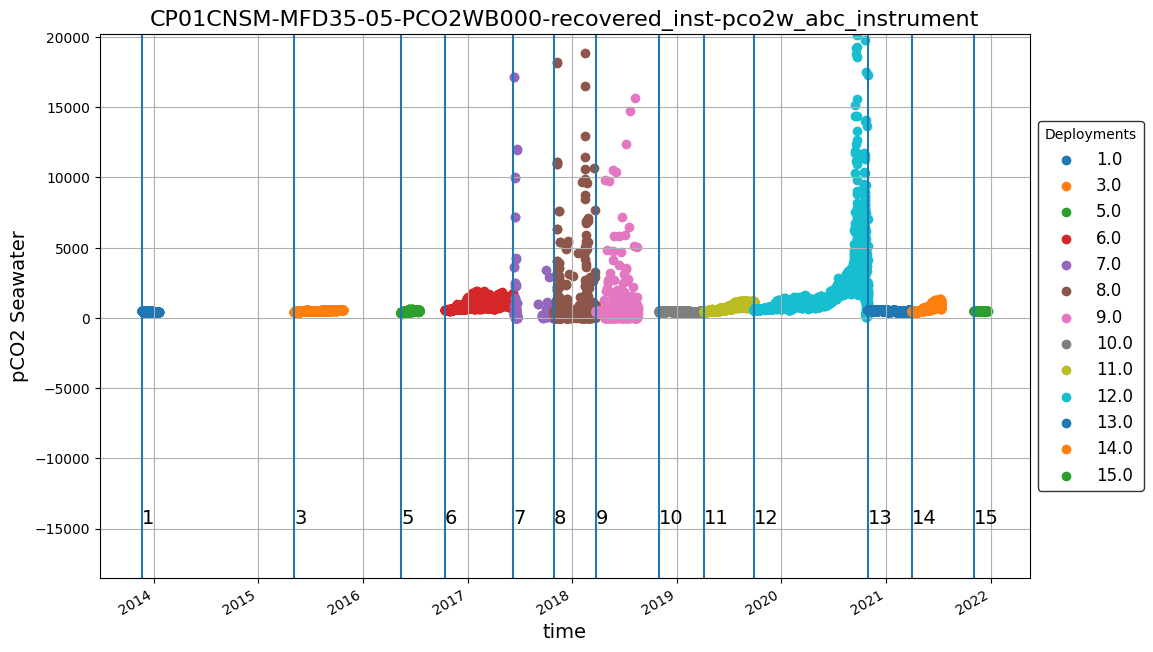

In [7]:
fig, ax = plot_variable(pco2w, "pco2_seawater")

We see from this figure that there have been 15 deployments of a ```PCO2W``` instrument at CP01CNSM-MFD35-05-PCO2WB000 (the Coastal Pioneer Central Surface Mooring - Seafloor Multifunction Node). We can also see that there are differences in variability both within deployments, such as deployment 1, and between deployments, such as the contrasting variability of deployment 11 vs. deployment 12.

The next step is to take a look at the annotations and see what they indicate about the data.

---
## Annotations

Since we are loading annotations which were previously downloaded and saved as a csv, we first need to do some parsing of the annotations to properly work with lists, etc. in the pandas dataframe.

In [8]:
annotations = load_annotations("../data/CP01CNSM-MFD35-05-PCO2WB000_annotations.csv")
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,104,CP01CNSM,MFD35,None,None,None,1485043200000,1.497024e+12,Multi-function Node was shut down due to low p...,False,lgarzio@marine.rutgers.edu,9,[]
1,.AnnotationRecord,288,CP01CNSM,MFD35,05-PCO2WB000,telemetered,pco2w_abc_dcl_instrument,1385057700000,1.547078e+12,"* UPDATED, 2019-01-25: After careful review, t...",False,friedrich.knuth@rutgers.edu,0,[931]
2,.AnnotationRecord,304,CP01CNSM,MFD35,05-PCO2WB000,recovered_host,pco2w_abc_dcl_instrument_recovered,1429898710000,1.547078e+12,"* UPDATED, 2019-01-25: After careful review, t...",False,friedrich.knuth@rutgers.edu,0,[931]
3,.AnnotationRecord,1562,CP01CNSM,MFD35,None,telemetered,None,1540904400000,1.554660e+12,Deployment 10: Power to MFN was lost immediate...,False,cdobson@whoi.edu,9,[]
4,.AnnotationRecord,571,CP01CNSM,MFD35,None,None,None,1432252800000,1.445629e+12,Deployment 3: Seafloor Multi-Function Node fai...,False,cdobson@whoi.edu,0,[]
5,.AnnotationRecord,3556,CP01CNSM,MFD35,None,None,None,1445626140000,1.459771e+12,Deployment 4: No instruments were deployed on...,False,swhite@whoi.edu,0,[]
6,.AnnotationRecord,4070,CP01CNSM,MFD35,None,None,None,1650024000000,NaN,Deployment 16: All MFN instruments have been o...,False,cdobson@whoi.edu,0,[]
7,.AnnotationRecord,3418,CP01CNSM,MFD35,None,None,None,1635950700000,1.649852e+12,Deployment 15: Due to a power issue all MFN in...,False,cdobson@whoi.edu,0,[]
8,.AnnotationRecord,497,CP01CNSM,MFD35,05-PCO2WB000,None,None,1385057700000,1.397779e+12,Recovered host data are not available.,False,leila@marine.rutgers.edu,0,[]
9,.AnnotationRecord,103,CP01CNSM,None,None,None,None,1392595200000,1.397779e+12,Surface buoy exploded due to hydrogen build-up...,False,swhite@whoi.edu,9,[]


Now we can look at a specific annotation. Lets see what the **```id```** 304 says:

In [9]:
annotations.loc[2, "annotation"]

'* UPDATED, 2019-01-25: After careful review, the original data product algorithm (pco2_pco2wat) for this sensor was found to contain an error that resulted in calculation of incorrect derived L1 pCO2 values. In consultation with the vendor, the algorithm has been corrected, verified, and uploaded to the OOI system. This update, effective 2019-01-10, applies to all deployments for this sensor. All derived L1\rpCO2 data products generated prior to this date should be re-requested in order to ensure utilization of the correct algorithm.  The updated algorithm can be viewed at https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/co2_functions.py.  * Until further notice, derived L1 pCO2 data products from this sensor are incorrect and should not be used. A significant discrepancy has been uncovered between the pCO2 values from shipboard water samples vs. values calculated by OOI system. The pco2_pco2wat algorithm is under review and can be viewed at https://g

Uh oh, this suggests that the derived pCO2 values are incorrect! However, since this a metadata error, we can go to https://oceanobservatories.org/metadatasearch/ to check on status and see that it has been resolved! Great

Now, we can add the "qc_flag" from the annotations to our dataset:

In [10]:
# Add in the annotation qc flags
pco2w = add_annotation_qc_flag(pco2w, annotations)

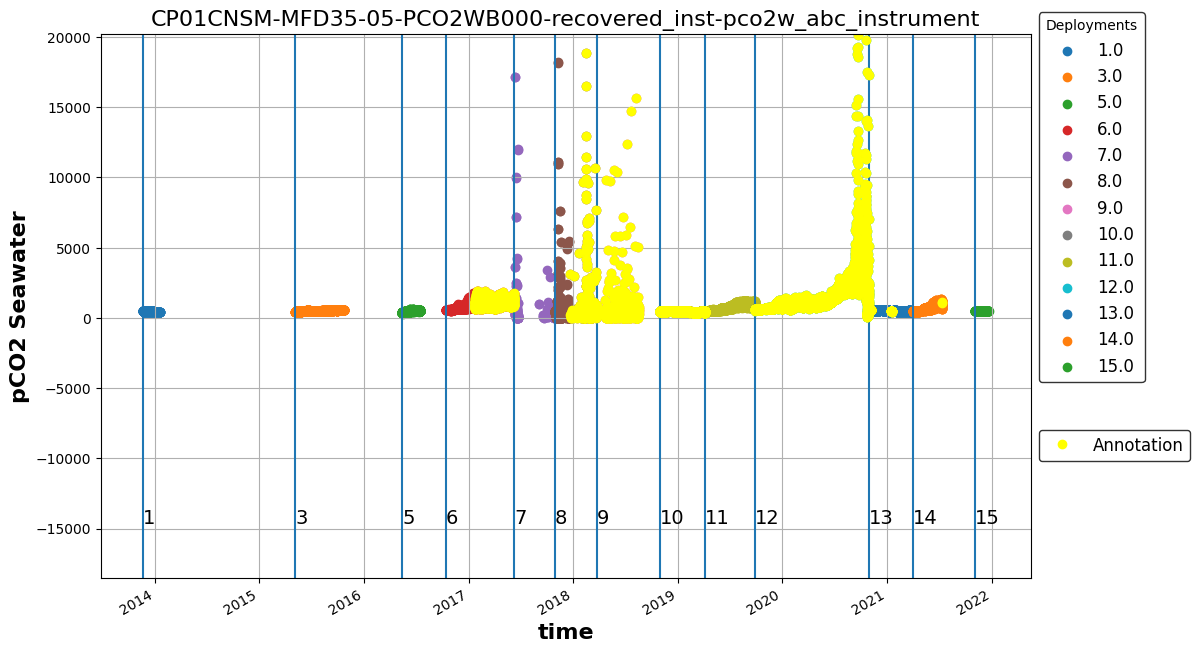

In [11]:
# Plot figure which highlights data points with a corresponding annotation
fig, ax = plot_variable(pco2w, "pco2_seawater")
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

s, = ax.plot(pco2w.time.where(pco2w.rollup_annotations_qc_results == 9), 
             pco2w.pco2_seawater.where(pco2w.rollup_annotations_qc_results == 9), 
             marker="o", linestyle="", color="yellow", label="Annotation")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)


We can see that there are annotations which cover a lot of the available ```PCO2W``` data. If desired, we can take a look at each individual annotation. For now we won't get rid of this data yet, but we will go ahead keep the highlighted data for now.

---
## Process for suspect data

This part of the workbook processes the data using code from data_explorations to remove bad datapoints. These values are based on conversations with Sunburst Instruments, LLC. and feedback from their experts. These flags should NOT be taken as truth, but as experienced guide to suspicious data.

In [12]:
sys.path.append("/home/areed/Documents/OOI/oceanobservatories/ooi-data-explorations/python/")

In [13]:
from ooi_data_explorations.uncabled.process_pco2w import quality_checks

#### Quality Checks

The quality checks which are run on the ```PCO2W``` data come from OOI consultations with Sunburst Sensors, LLC, and were coded into python by Chris Wingard (OOI - Coast Endurance). The quality checks examine the instrument blanks, variability, and signal strength to determine if the measured seawater pCO$_{2}$ is suspect due to poor measurement. The flags used here correspond to standard QARTOD QC-flagging, with 1 = good, 3 = suspect, and 4 = bad.

In [14]:
pco2w["pco2_seawater_quality_checks"] = quality_checks(pco2w)

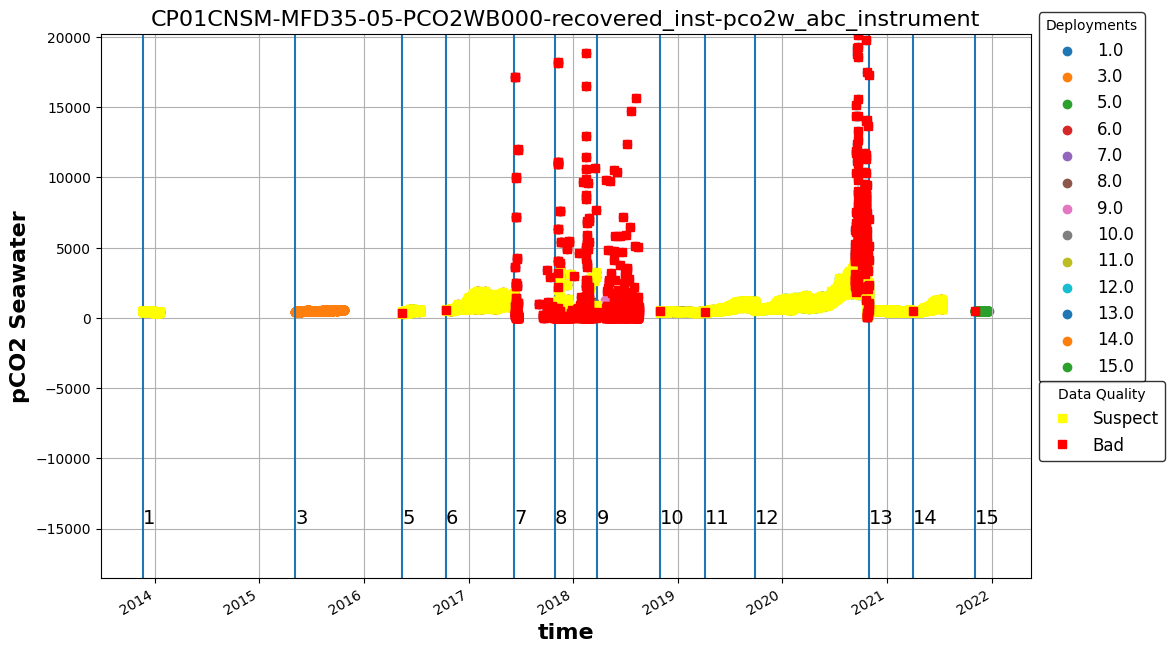

In [15]:
# Plot the data quality checks
fig, ax = plot_variable(pco2w, "pco2_seawater", add_deployments=True)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)

f1, = ax.plot(pco2w.time.where(pco2w.pco2_seawater_quality_checks == 3), 
             pco2w.pco2_seawater.where(pco2w.pco2_seawater_quality_checks == 3),
             marker="s", linestyle="", color="yellow", label="Suspect")

f2, = ax.plot(pco2w.time.where(pco2w.pco2_seawater_quality_checks == 4), 
             pco2w.pco2_seawater.where(pco2w.pco2_seawater_quality_checks == 4),
             marker="s", linestyle="", color="red", label="Bad")

ax.legend(handles=[f1, f2], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12, title="Data Quality")


From the above figure, we can see that a lot of the time periods of large variability have been flagged as "bad". We can go ahead and remove the bad and suspect data from the ```PCO2W``` dataset, leaving us with the "good" ```PCO2W``` data. 

In [16]:
# Now, remove the bad data
pco2w_good = pco2w.where(pco2w.pco2_seawater_quality_checks == 1, drop=True)

Text(0, 0.5, 'pCO2 Seawater')

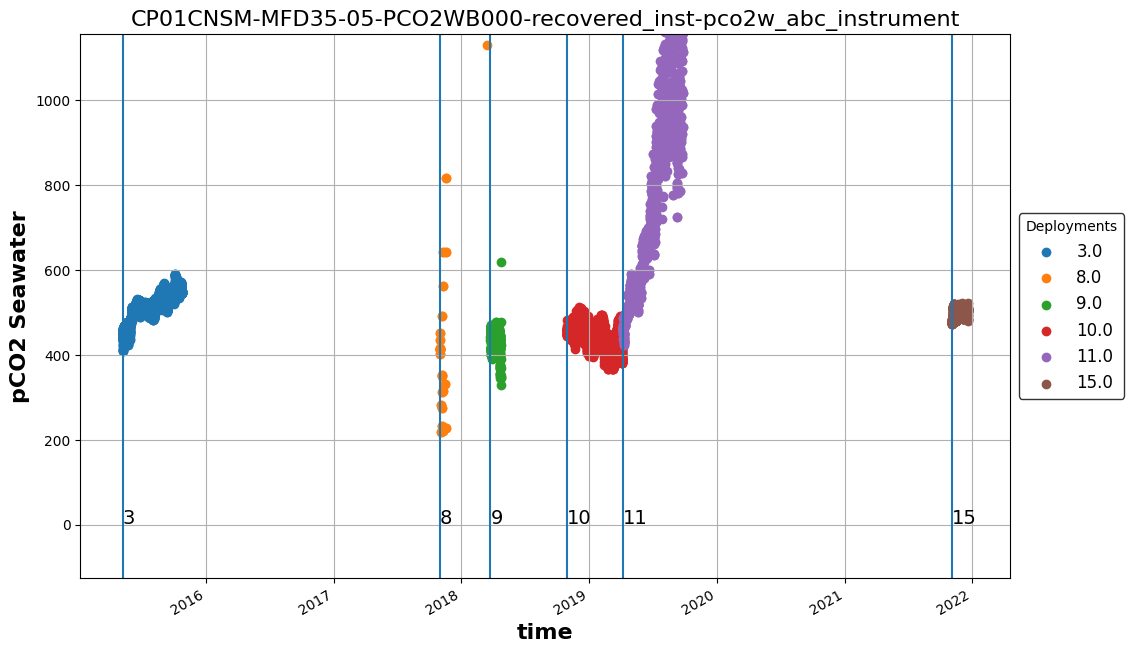

In [17]:
fig, ax = plot_variable(pco2w_good, "pco2_seawater")
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

Ouch, that removed a *lot* of the available data! We can always reduce how strict we are with what passes the quality checks and include data flagged as **3** and see how that increases the available data after filtering.

In [18]:
pco2w_decent = pco2w.where(pco2w.pco2_seawater_quality_checks != 4, drop=True)

Text(0, 0.5, 'pCO2 Seawater')

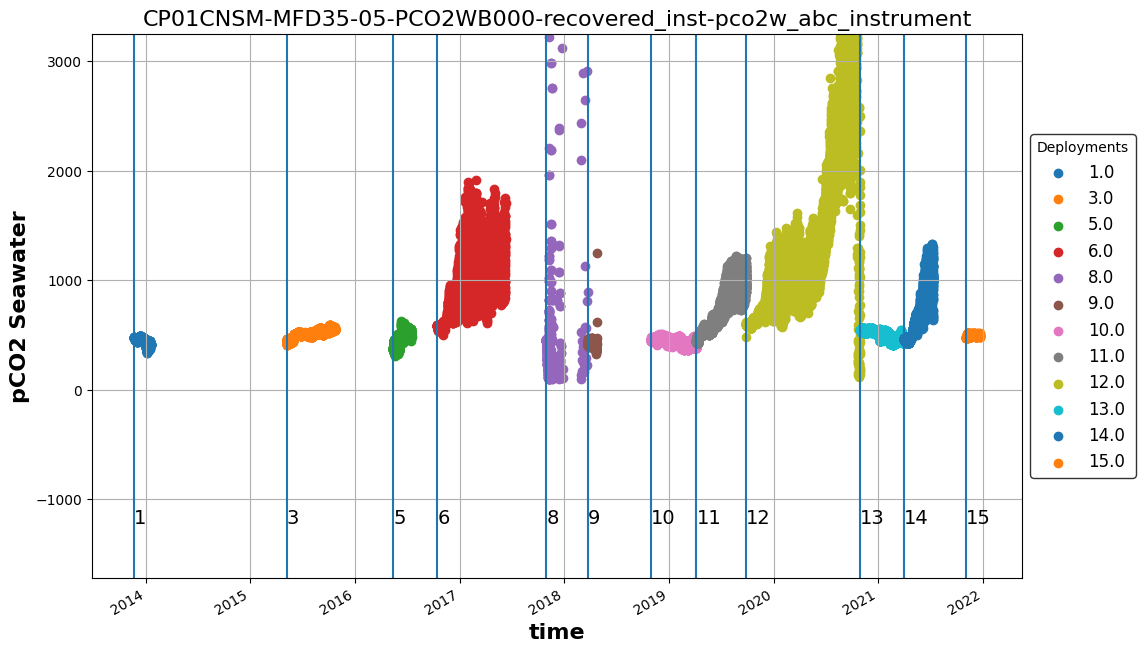

In [19]:
fig, ax = plot_variable(pco2w_decent, "pco2_seawater")
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

Keeping data flagged both **1** and **3** significantly increased the amount of data after filtering. This, of course, is always a judgement call on what your scientific needs are.

---
## Bottle Data

The next step is to start comparing the PHSEN-measured seawater pH against the pH measured via Niskin collection and lab analysis. We start by loading all of the availabe Global Irminger Sea Array > Discrete Sample Summary sheets into a pandas dataframe. 

Once the bottle data is loaded, we need to do some processing to make the data easier to work with in python with pandas. The processing steps we'll take include:
1. Replacing fill values with NaNs
2. Parsing and converting timestamps
3. Replacing odd/unexpected values
4. Interpreting the quality flags to correspond to QARTOD QC standards
5. Filtering out bad data

In [51]:
from ooinet.Bottles import *

In [52]:
bottle_dir = "../data/bottle_data/"
bottle_data = pd.DataFrame()
for file in os.listdir(bottle_dir):
    bottle_data = bottle_data.append(pd.read_excel(bottle_dir + file), ignore_index=True)

Replace the fill value of ```-9999999``` with NaNs:

In [53]:
bottle_data = bottle_data.replace(to_replace="-9999999", value=np.nan)
bottle_data = bottle_data.replace(to_replace=-9999999, value=np.nan)

Convert times from strings to pandas datetime objects and remove the timezone:

In [54]:
bottle_data["Start Time [UTC]"] = bottle_data["Start Time [UTC]"].apply(lambda x: convert_times(x))
bottle_data["CTD Bottle Closure Time [UTC]"] = bottle_data["CTD Bottle Closure Time [UTC]"].apply(lambda x: convert_times(x))

Convert any values with a "<", which indicates a value not statistically significant from zero, with zero:

In [55]:
bottle_data = bottle_data.applymap(not_statistically_sigificant)

#### Filter data
Next, we want to filter the data based on the data flag associated with the sample. First, we should drop all of the ```NaN``` values in the Niskin column to eliminate entries without any bottle samples. While these CTD casts may be of interest, the bottle data does not have the relevant data.

In [56]:
# Deployment
for col in bottle_data.columns:
    if "Flag" in col:
        if "CTD" in col and "File" not in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_ctd_flag(x))
        elif "Discrete" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_discrete_flag(x))
        elif "Replicate" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_replicate_flag(x))
        elif "Niskin" in col:
            bottle_data[col] = bottle_data[col].apply(lambda x: interp_niskin_flag(x))
        else:
            pass

In [57]:
bottle_data.head()

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated DIC [umol/kg],Calculated pCO2 [uatm],Calculated pH,Calculated CO2aq [umol/kg],Calculated Bicarb [umol/kg],Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,Unnamed: 80,Unnamed: 81
0,AR24A,1,LTER - 1,NaN,NaN,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
1,AR24A,2,LTER - 2,40.9645,-70.830500,2017-10-22 21:14:41+00:00,002,*0000000000000100,NaN,AR24002.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
2,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
3,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN
4,AR24A,3,LTER - 3,40.7985,-70.831167,2017-10-22 22:38:07+00:00,003,*0000000000000100,NaN,AR24003.hex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ancillary CTD cast - LTER,NaN


---
### Calculate Carbon System Parameters
---
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. I calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

In [27]:
# Calculate the Carbon System Parameters
from PyCO2SYS import CO2SYS

---
### Calculate Physical Properties
With the bottle samples cleaned up, we next want to calculate the conservative seawater properties, such as density, conservative temperature, absolute salinity, etc., using the updated TEOS properties with the ```gsw``` package.

In [28]:
import gsw

In [29]:
# ======================================================================
# Deployment: Calculate some key physical parameters to get density based on TEOS-10
SP = bottle_data[["CTD Salinity 1 [psu]", "CTD Salinity 2 [psu]"]].mean(axis=1)
T = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
P = bottle_data["CTD Pressure [db]"]
LAT = bottle_data["CTD Latitude [deg]"]
LON = bottle_data["CTD Longitude [deg]"]

# Absolute salinity
SA = gsw.conversions.SA_from_SP(SP, P, LON, LAT)
bottle_data["CTD Absolute Salinity [g/kg]"] = SA

# Conservative temperature
CT = gsw.conversions.CT_from_t(SA, T, P)
bottle_data["CTD Conservative Temperature"] = CT

# Density
RHO = gsw.density.rho(SA, CT, P)
bottle_data["CTD Density [kg/m^3]"] = RHO

# Calculate potential density
SIGMA0 = gsw.density.sigma0(SA, CT)
bottle_data["CTD Sigma [kg/m^3]"] = RHO

del SP, T, P, LAT, LON, SA, CT, RHO, SIGMA0

---
### Calculate Carbon System Parameters
The discrete water samples were tested for Total Alkalinity, Dissolved Inorganic Carbon, and pH [Total Scale]. We can calculate the discrete water sample pCO<sub>2</sub> concentrations from the TA and DIC using the ```CO2SYS``` program. 

Use of ```CO2SYS``` requires, at a minimum, the following inputs:
* ```PAR1```: First measured carbon system measurement
* ```PAR2```: Second measured carbon system measurement
* ```PAR1_type```: The type of PAR1 
        * 1 = Total Alkalinity umol/kg
        * 2 = DIC umol/kg
        * 3 = pH Total Scale
        * 4 = pCO2
        * 5 = fCO2
* ```PAR2_type```: The type of PAR2

The following are optional hydrographic inputs:
* ```salinity```: practical salinity
* ```temperature```: the temperature at which PAR1 and PAR2 are provided (in C)
* ```pressure```: the water pressure at which ```PAR1``` and ```PAR2``` are measured

The ```CO2SYS``` program calculations use carbonic acid dissociation coefficients K1 and K2 from Leuker et al. (2000), sulfate dissociation constant KSO4 from Dickson (1990), total borate concentration from Lee et al. (2010), and HF dissociation coefficient KHF from Perez and Fraga (1987) were used in carbonate system calculations. Input temperatureand pressure is set to the temperature and pressure that pH samples were processed at (25 degrees celcius, 0 dbar) and output temperature and pressure was set to in-situ conditions.

In [30]:
PAR1 = bottle_data['Discrete Alkalinity [umol/kg]']
PAR2 = bottle_data['Discrete DIC [umol/kg]']
PAR1TYPE = 1
PAR2TYPE = 2
SAL = bottle_data['Discrete Salinity [psu]']
TEMPIN = 25
TEMPOUT = bottle_data[["CTD Temperature 1 [deg C]", "CTD Temperature 2 [deg C]"]].mean(axis=1)
PRESIN = 0
PRESOUT = bottle_data['CTD Pressure [db]']
SI = bottle_data['Discrete Silicate [uM]'].fillna(value=0)
PO4 = bottle_data['Discrete Phosphate [uM]'].fillna(value=0)
PHSCALEIN = 1
K1K2CONSTANTS = 1
K2SO4CONSTANTS = 1

With the relevant parameters declared, pass the values into ```CO2SYS``` and get out the calculated values:

In [31]:
CO2dict = CO2SYS(PAR1, PAR2, PAR1TYPE, PAR2TYPE, SAL, TEMPIN, TEMPOUT, PRESIN, PRESOUT, SI, PO4, PHSCALEIN, K1K2CONSTANTS, K2SO4CONSTANTS)

Now add the calculated carbon system parameters to the cruise info:

In [32]:
bottle_data['Calculated Alkalinity [umol/kg]'] = CO2dict['TAlk']
bottle_data['Calculated CO2aq [umol/kg]'] = CO2dict['CO2out']
bottle_data['Calculated CO3 [umol/kg]'] = CO2dict['CO3out']
bottle_data['Calculated DIC [umol/kg]'] = CO2dict['TCO2']
bottle_data['Calculated pCO2 [uatm]'] = CO2dict['pCO2out']
bottle_data['Calculated pCO2in'] = CO2dict['pCO2in']
bottle_data['Calculated pH'] = CO2dict['pHoutTOTAL']

#### Compare Bottle and ```PCO2W``` Data

With the Discrete Bottle pCO2 now calculated for in-situ conditions, we can begin to compare the Bottle pCO2 with the PCO2W-measured pCO2. First, we need to identify which bottle measurements occurred where the PCO2W instrument is located.

Helpfully, the PCO2W datasets returned from OOI contain the latitude and longitude of the buoy where it was deployed. Additionally, we can get the **```Deployment```** information for the PCO2W reference designator, which includes the deployed depth. Using those two pieces of info, we can search the bottle data for measurements which occured within some set distance and depth of the PCO2W. 

For the Global Irminger Sea Array, a fairly relaxed maximum distance can be used, due to larger horizontal scales of variability. In comparison, observations at the Coastal Arrays - Pioneer and Endurace - should utilize smaller maximum distances.

In order to get the deployed depths, we need to query the deployment information from OOINet:

In [34]:
deployments = M2M.get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-PCO2WB-C0069,2355,40.13678,-70.76978,132.5,2013-11-21 18:16:00,2014-04-18 10:33:00,KN214,KN217
1,2,CGINS-PCO2WB-C0096,2227,40.1339,-70.7789,134.0,2014-12-13 18:47:00,2014-12-15 20:58:00,KN224,KN224
2,3,CGINS-PCO2WB-C0096,2227,40.14022,-70.77128,134.0,2015-05-07 17:34:00,2015-10-23 19:40:00,AT27,AT31
3,5,CGINS-PCO2WB-C0051,2310,40.14037,-70.77133,133.0,2016-05-13 13:50:00,2016-10-13 19:34:00,AR4,AR8
4,6,CGINS-PCO2WB-C0069,2355,40.13342,-70.77847,133.0,2016-10-13 18:36:00,2017-06-09 16:05:00,AR8,AR18
5,7,CGINS-PCO2WB-C0070,2169,40.139817,-70.77115,133.0,2017-06-09 14:24:00,2017-11-01 20:33:00,AR18,AR24
6,8,CGINS-PCO2WB-C0098,2237,40.133383,-70.7783,133.0,2017-10-29 14:15:00,2018-03-29 19:37:00,AR24,AR28
7,9,CGINS-PCO2WB-C0096,2227,40.13975,-70.77128,133.0,2018-03-24 21:32:00,2018-10-29 12:31:00,AR28,AR31
8,10,CGINS-PCO2WB-C0135,1815,40.133367,-70.7777,133.0,2018-10-30 01:48:00,2019-04-07 18:08:00,AR31,AR34
9,11,CGINS-PCO2WB-C0098,2237,40.1401,-70.77137,132.0,2019-04-06 14:35:00,2019-09-26 17:15:00,AR34,AR39


In [35]:
deployment_depth = deployments["depth"].mean()

In [36]:
pco2w.lat, pco2w.lon, deployment_depth

(40.13678, -70.76978, 132.9)

Identify the bottle samples which are associated with samples collected near the PCO2W instrument we are looking at. Here I utilize a horizontal maximum distance of 5 kilometers and a depth theshold of +/- 10 meters.

In [37]:
pco2w_bottles = findSamples(bottle_data, (pco2w.lat, pco2w.lon), deployment_depth, 5, 10)
pco2w_bottles

,Cruise,Station,Target Asset,Start Latitude [degrees],Start Longitude [degrees],Start Time [UTC],Cast,Cast Flag,Bottom Depth at Start Position [m],CTD File,...,Calculated CO3 [umol/kg],Calculated Omega-C,Calculated Omega-A,Unnamed: 80,Unnamed: 81,CTD Absolute Salinity [g/kg],CTD Conservative Temperature,CTD Density [kg/m^3],CTD Sigma [kg/m^3],Calculated pCO2in
38,AR24A,14,CN,40.138667,-70.779167,2017-10-24 23:10:09+00:00,014,*0000000000000100,132.0,AR24014.hex,...,NaN,NaN,NaN,Cross-shelf survey,NaN,35.667976,13.613647,1027.222968,1027.222968,NaN
101,AR24B,7,CNSM,40.135667,-70.774500,2017-10-29 14:42:27+00:00,007,*0000000000000100,132.0,AR24b007.hex,...,131.756139,NaN,NaN,NaN,NaN,35.791763,13.804714,1027.279167,1027.279167,896.348194
102,AR24B,7,CNSM,40.135667,-70.774500,2017-10-29 14:42:27+00:00,007,*0000000000000100,132.0,AR24b007.hex,...,NaN,NaN,NaN,NaN,NaN,35.790005,13.804366,1027.277621,1027.277621,NaN
178,AR24B,14,CN,40.136500,-70.774000,2017-11-03 16:05:46+00:00,014,*0000000000000100,131.0,AR24b014.hex,...,NaN,NaN,NaN,AUV survey at CN site,NaN,35.823573,14.316531,1027.201374,1027.201374,NaN
179,AR24B,14,CN,40.136500,-70.774000,2017-11-03 16:05:46+00:00,014,*0000000000000100,131.0,AR24b014.hex,...,NaN,NaN,NaN,AUV survey at CN site,NaN,35.824276,14.314570,1027.202226,1027.202226,NaN
216,AR24C,2,CNPM,40.136833,-70.774667,2017-11-06 15:22:07+00:00,002,*0000000000000100,133.0,ar24c002.hex,...,139.587606,NaN,NaN,NaN,NaN,35.870531,13.972512,1027.298930,1027.298930,835.466301
217,AR24C,2,CNPM,40.136833,-70.774667,2017-11-06 15:22:07+00:00,002,*0000000000000100,133.0,ar24c002.hex,...,NaN,NaN,NaN,"duplicate DIC/TA, S, O2, Chl, nutrients",NaN,35.870783,13.970587,1027.300205,1027.300205,NaN
304,AR8A,7,CN,40.134000,-70.776667,2016-09-29 18:46:21+00:00,7,*0000000000000100,133.0,ar08a007.hex,...,NaN,NaN,NaN,cross shelf survey,NaN,35.832288,13.540978,1027.350731,1027.350731,NaN
411,AR8B,7,CNSM,40.136167,-70.774667,2016-10-13 22:06:23+00:00,7,*0000000000000100,134.0,ar08b007.hex,...,132.510265,NaN,NaN,O2 Min,NaN,35.750968,13.693082,1027.269323,1027.269323,886.109478
412,AR8B,7,CNSM,40.136167,-70.774667,2016-10-13 22:06:23+00:00,7,*0000000000000100,134.0,ar08b007.hex,...,NaN,NaN,NaN,NaN,NaN,35.750918,13.693064,1027.269902,1027.269902,NaN


(15883.293438733217, 19129.254893083915)

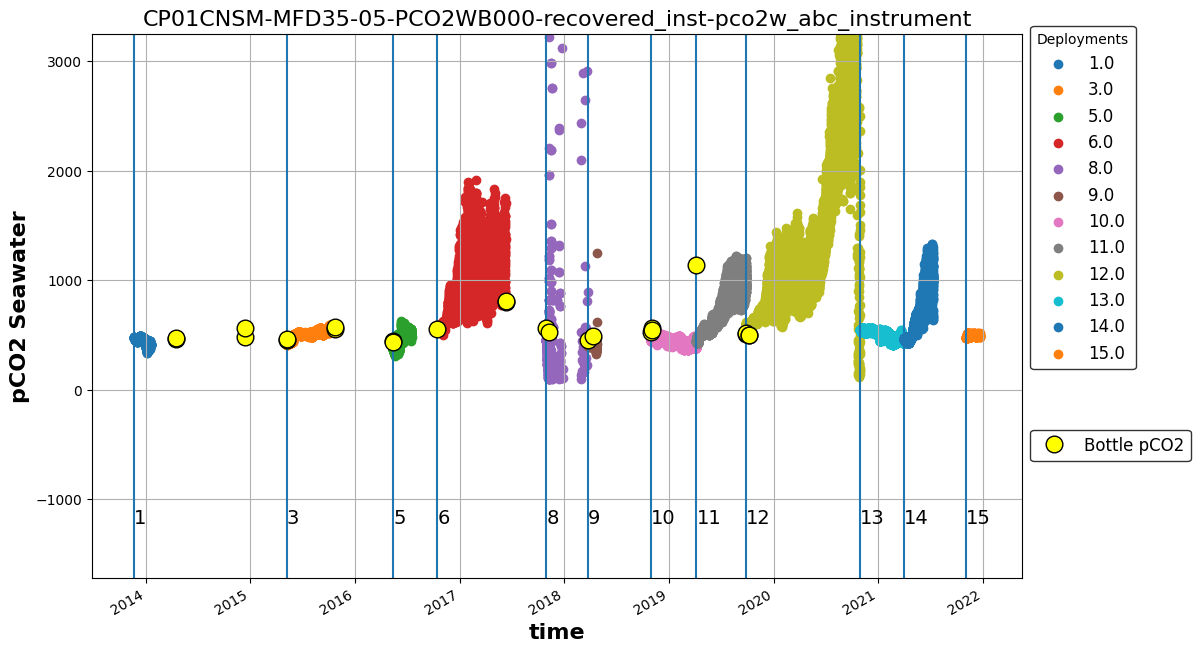

In [38]:
# Plot the selected bottle data against the PHSEN data
fig, ax = plot_variable(pco2w_decent, "pco2_seawater")
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")
first_legend = ax.get_legend()
first_legend.set_bbox_to_anchor((1, 0.7))
ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

s, = ax.plot(pco2w_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Start Time [UTC]"], 
             pco2w_bottles.dropna(subset=["Calculated pCO2 [uatm]"])["Calculated pCO2 [uatm]"], 
             marker="o", color="yellow", linestyle="", markersize=12, markeredgecolor = "black",
             label="Bottle pCO2")

ax.legend(handles=[s], edgecolor="black", loc="lower left", bbox_to_anchor=(1, 0.2), fontsize=12)
ax.set_xlim(xmin, xmax)

In the above figure, we can see that deployments 3 and 6 have discrete bottle data that were collected at deployment and during recovery. For convience, we'll take a look at deployment 3 with the bottle data.

First, select just the PCO2W data associated with deployment 3:

In [39]:
pco2w_dep3 = pco2w_decent.where(pco2w_decent.deployment == 3, drop=True)
pco2w_dep3

<xarray.Dataset>
Dimensions:                             (time: 4331, duplicates: 2)
Coordinates:
  * duplicates                          (duplicates) int32 0 1
  * time                                (time) datetime64[ns] 2015-05-07T18:0...
Data variables: (12/25)
    absorbance_blank_434                (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    absorbance_blank_620                (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    absorbance_ratio_434                (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    absorbance_ratio_620                (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    battery_voltage                     (time) float32 dask.array<chunksize=(4331,), meta=np.ndarray>
    dark_reference                      (time, duplicates) float64 dask.array<chunksize=(4331, 2), meta=np.ndarray>
    ...                                  ...
    thermistor_temperature              (time) float32 dask.array<chunksize=(4331,), meta=np.ndarray>
    thermistor_temperature_qc_executed  (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    thermistor_temperature_qc_results   (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    unique_id                           (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    rollup_annotations_qc_results       (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
    pco2_seawater_quality_checks        (time) float64 dask.array<chunksize=(4331,), meta=np.ndarray>
Attributes: (12/70)
    node:                               MFD35
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             pco2w_abc_instrument
    ...                                 ...
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                40.13678
    lon:                                -70.76978
    Location_name:                      Coastal Pioneer Central Surface Moori...

Find the nearest bottle samples to the start and end of deployment 3:

In [40]:
dt = pd.Timedelta(days=1)
tmin = pd.to_datetime(pco2w_dep3.time.min().values, utc=True) - dt
tmax = pd.to_datetime(pco2w_dep3.time.max().values, utc=True) + dt

pCO2_data = pco2w_bottles.dropna(subset=["Calculated pCO2 [uatm]"])
pCO2_data_dep3 = pCO2_data[(pCO2_data["Start Time [UTC]"] >= tmin) & (pCO2_data["Start Time [UTC]"] <= tmax)]

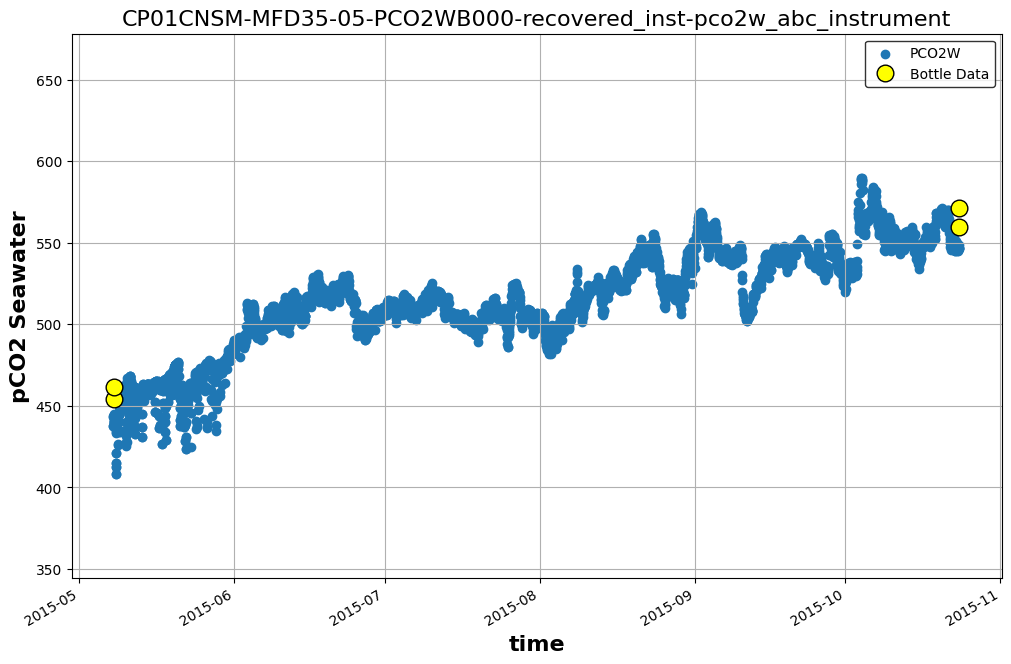

In [41]:
# Plot a comparison of Deployment 3 PHSEN and Bottle data
fig, ax = plot_variable(pco2w_dep3, "pco2_seawater", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

ax.plot(pCO2_data_dep3["Start Time [UTC]"], pCO2_data_dep3["Calculated pCO2 [uatm]"], 
        marker="o", linestyle="", color="yellow", markersize=12, markeredgecolor="black")
ax.legend(["PCO2W", "Bottle Data"], edgecolor="black")


In order to do direct comparisons, we will average all of the ```PCO2W``` sensor pCO2 which was measured within $\pm$12 hours of the bottle measurement.

In [42]:
pCO2_data_dep3["Start Time [UTC]"] = pCO2_data_dep3["Start Time [UTC]"].apply(lambda x: x.tz_localize(None))

In [43]:
# Get the data to directly compare values
# Find data which is +/- 12-hours of each bottle to normalize over a daily-cycle
dt = pd.Timedelta(hours=12)
results = pd.DataFrame(columns=["Time", "Avg", "Std"])
for t in pCO2_data_dep3["Start Time [UTC]"]:
    mask = pco2w_dep3.time[(pco2w_dep3.time <= t + dt) & (pco2w_dep3.time >= t-dt)]
    pCO2_pco2w_avg = pco2w_dep3["pco2_seawater"][(pco2w_dep3["time"] >= t-dt) & (pco2w_dep3["time"] <= t + dt)].mean().values
    pCO2_pco2w_std = pco2w_dep3["pco2_seawater"][(pco2w_dep3["time"] >= t-dt) & (pco2w_dep3["time"] <= t + dt)].std().values
    results = results.append({
        "Time": t,
        "Avg": pCO2_pco2w_avg,
        "Std": pCO2_pco2w_std
    }, ignore_index=True)

Plot the comparison of the bottle data against the ```PCO2W``` data:

Text(0, 0.5, 'Sensor pCO2')

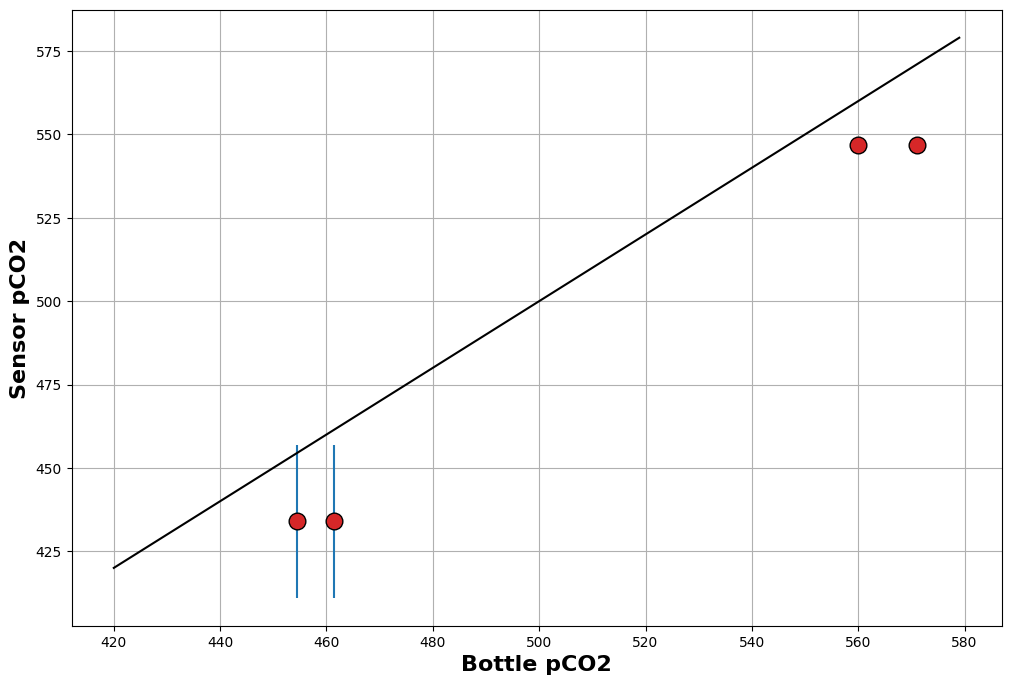

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

line = np.arange(420, 580, 1)
ax.vlines(pCO2_data_dep3["Calculated pCO2 [uatm]"], results["Avg"]-results["Std"]*2, results["Avg"]+results["Std"]*2)
ax.plot(pCO2_data_dep3["Calculated pCO2 [uatm]"], results["Avg"], marker="o", linestyle="", color="tab:red", markeredgecolor="black", markersize=12)
s, = ax.plot(line, line, color="black")
ax.grid()
ax.set_xlabel("Bottle pCO2", fontsize=16, fontweight="bold")
ax.set_ylabel("Sensor pCO2", fontsize=16, fontweight="bold")

The above figure shows that, within the variability of the ```PCO2W```, the instrument measures the correct pCO2 in the water as determined by laboratory analysis at the beginning of the instrument's deployment. 

If we want, we can try to correct the time series data for the differences at the beginning and end of the deployment. However, for the Sunburst SAMI-pCO2 sensor, this is not considered best practice because the relative measurement made by the instrument is supposed to be self-correcting and thus immune to drift.

In [45]:
# Calculate the difference between the sensor and bottle pH
pCO2_data_dep3["delta pCO2"] = results["Avg"].values - pCO2_data_dep3["Calculated pCO2 [uatm]"].values
pCO2_data_dep3["delta pCO2"]

891    -20.410551
892    -27.518424
1442   -13.163106
1443    -24.38896
Name: delta pCO2, dtype: object

In [46]:
pCO2_data_dep3["CTD Bottle Closure Time [UTC]"]

891    2015-05-07 23:15:02+00:00
892    2015-05-07 23:15:13+00:00
1442   2015-10-23 20:13:24+00:00
1443   2015-10-23 20:13:41+00:00
Name: CTD Bottle Closure Time [UTC], dtype: datetime64[ns, UTC]

In [47]:
(pCO2_data_dep3["CTD Bottle Closure Time [UTC]"] - pCO2_data_dep3["CTD Bottle Closure Time [UTC]"].loc[891]).apply(lambda x: pd.Timedelta.total_seconds(x))

891            0.0
892           11.0
1442    14590702.0
1443    14590719.0
Name: CTD Bottle Closure Time [UTC], dtype: float64

Calculate the drift correction for the pH data based on the $\Delta$pH between the sensor and the bottle data, and using linear algrebra: <br>

<p align="center">
    $y = \beta*X$ -> $\beta = (X^{T}X)^{-1}X^{T}y$
</p>

In [48]:
# Set up the equation matrix
X = np.matrix([[1, 0],[1, 11], [1, 14590702], [1, 14590719]])

# Transpose
XT = np.matrix.transpose(X)

# Results matrix
y = np.matrix([[-20.410551], 
               [-27.518424],
               [-13.163106],
               [-24.38896]])

# Multiply the transposes
XT_X = np.matmul(XT, X)


XT_y = np.matmul(XT, y)

# Solve for the coefficients and get the slope and intercept based on OLS
betas = np.matmul(np.linalg.inv(XT_X), XT_y)
intercept, slope = float(betas[0]), float(betas[1])
print(intercept)
print(slope)

-23.964484846247657
3.5559935458241395e-07


Now calculate the correction as sensor pCO2 + ($\Delta$pCO2 * slope * $\Delta$time + intercept) 

In [49]:
dT = ((pco2w_dep3["time"] - pco2w_dep3["time"][0])/1E9).astype(int)
correction = intercept + slope*dT
pco2w_dep3["pco2_seawater_corrected"] = pco2w_dep3["pco2_seawater"] + correction

Plot the comparison

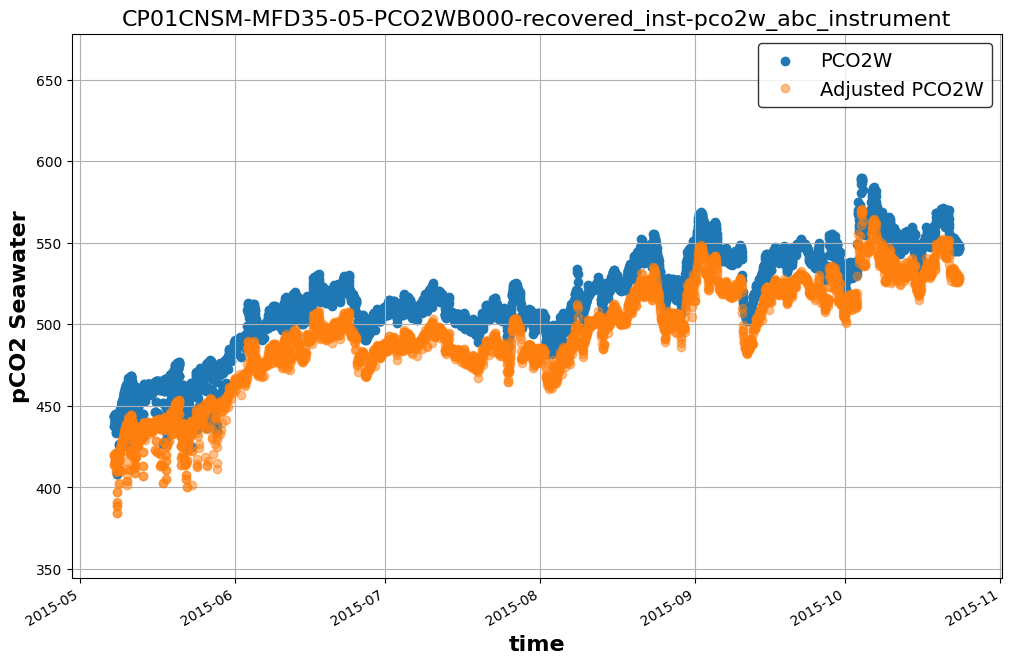

In [50]:
fig, ax = plot_variable(pco2w_dep3, "pco2_seawater", add_deployments=False)
ax.set_alpha(0.7)
ax.set_xlabel(ax.get_xlabel(), fontsize=16, weight="bold")
ax.set_ylabel(ax.get_ylabel(), fontsize=16, weight="bold")

ax.plot(pco2w_dep3["time"], pco2w_dep3["pco2_seawater_corrected"], 
        marker="o", linestyle="", color="tab:orange", alpha=0.5)
ax.legend(["PCO2W", "Adjusted PCO2W"], edgecolor="black", fontsize=14)